# Machine Learning in Python - Project 1
Ishaan Jolly (s1665110), Stephen Gallagher (s2116339), Mariel Reyes-Salazar (s2123659), Julia Stachurska (s2131144)

# Introduction
For this paper, we intensively worked together with NBC Studios, where some of the most popular, American shows are made. We investigated the features of a famous TV series "The Office" and learned what makes one episode more popular than the other. We then used those findings to build a predictive model that represents the nature of the relationship between features and audience ratings. The ultimate goal of this project is to use the insights gained from our predictive model to advise those at NBC Universal on the creation of a special reunion episode of The Office with the highest IMDb rating possible. Data for this project is derived from the data available in the [`schrutepy`] package at: https://pypi.org/project/schrutepy/.

First, we perform preprocessing and basic exploratory analysis of the dataset, and find the distribution of the IMDb ratings. Then, we perform the character analysis by finding the most common characters in the show and creating a visualisation of the important characters with the highest number of spoken lines. Next, we turn to the writer analysis. We do not consider writers that contributed to less than 2 episodes in the series and find which writers wrote the best scripts. We investigate which directors have the highest success in producing the episodes. We compare various models: linear model, ridge, ridge kernel, lasso, and decision trees. Our final choice is the ridge regression model offering a good predictive performance using the selected features.

# Exploratory Data Analysis and Feature Engineering

## Setup

In [37]:
# Install required packages
!pip install -q -r requirements.txt

### Importing Libraries
In this section we import the relevant libraries required for our data analysis.

In [38]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np
import statistics as stats
import scipy

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

# regular expressions module
import re

# importing schrutepy dataset
from schrutepy import schrutepy

### Importing datasets

In this section we import the relevant datasets required for our data analysis.

In [39]:
# Schrute dataset (Auxiliary dataset for exploratory purposes)
schrute = schrutepy.load_schrute()

In [40]:
# Main dataset
d = pd.read_csv("the_office.csv")

### Helper Functions

In this section we define two helper functions:
- `match_person`, which helps to find a specific character or writer in the series.
- `match_phrase`, which helps to find a specific phrase said by one of the characters at one point in the series.

In [41]:
def match_person(name, col, df):

    '''
    Helper function for finding a character or a writer in the dataframe

    inputs:
    name: Person name
    col: Column to search in the dataframe
    df: Dataframe to search

    output:
    matched: Subset of the dataframe with the episodes where the character or writer is found
    '''

    name_exp = f".*({name}).*"
    reg_exp = re.compile(name_exp, re.I)
    matched = df[df[f"{col}"].str.match(reg_exp)==True]
    return matched
    match_person(mich)
    
def match_phrase(phrase, col, df):
    
    '''
    Helper function for finding a specific phrase in the dataframe

    inputs:
    phrase: Phrase to look
    col: Column to search in the dataframe
    df: Dataframe to search

    output:
    matched: Subset of the dataframe with the episodes where the phrase is found
    '''

    phrase_exp = f".*({phrase}).*"
    reg_exp = re.compile(phrase_exp, re.I)
    matched = df[df[f"{col}"].str.match(reg_exp)==True]
    return matched

### Data Cleaning

We found several instances of misspelt director names in the main dataset, which were corrected using the following block of code:

In [42]:
# Grouping by director names
grouped = d.groupby(by=["director"], dropna=False).sum()
directors = grouped.index
directors_list = [i for i in directors]
directors_list

# Incorrect names: Charles McDougal, Claire Scalong, Claire Scalon, Paul Lieerstein, Ken Wittingham, Greg Daneils 
d["director"] = np.where(d["director"] == "Charles McDougal", "Charles McDougall", d["director"])
d["director"] = np.where(d["director"] == "Paul Lieerstein", "Paul Lieberstein", d["director"])
d["director"] = np.where(d["director"] == "Ken Wittingham", "Ken Whittingham", d["director"])
d["director"] = np.where(d["director"] == "Greg Daneils", "Greg Daniels", d["director"])
d["director"] = np.where(d["director"] == "Claire Scanlong", "Claire Scanlon", d["director"])
d["director"] = np.where(d["director"] == "Claire Scalon", "Claire Scanlon", d["director"])

We also found an instance of a misspelt writer name, which we corrected with the following block of code:

In [43]:
# Checking for incorrect writer names 
grouped = d.groupby(by=["writer"], dropna=False).sum()
writer = grouped.index
writer_list = [i for i in writer]
writer_list

# Incorrect names:Jonathan Huges
d["writer"] = np.where(d["writer"] == "Jonathan Huges", "Jonathan Hughes", d["writer"])

We also found several instances is misspelt character and writer names in the schrutepy dataset, which we corrected with the following function:

In [44]:
# Cleaning character names in Schrutepy dataset

def clean_names_schrutepy():

    # Dictionary of correct names (keys) and their regular expressions (values)
    regex_list = ['.*(mic\w*el\s$|mic.*\x5D|m\w*ael|m*i*c\w*)', '.*(dar.*\x5D|d*a*r\w*)', 
    '.*(a*ng\w*"|a*ng\w*)', '.*(sta*n\w*)', '.*(de\w*elo)', '.*(sand\w*)', '.*(abe\w*)', 
    '.*("jim"|jim"|jim\w*)', '.*(ph.*l.*s"|ph.*l.*s)', '.*(A.J.)', '(Gw\w*eth)', 
    '.*(dw\w*ht\x2E|dw\w*tte|d\w*ght)', '.*("jo")', '(pa\w*m\s$)', '(hele*n$)']  

    correct_names = ["Michael", "Darryl", "Angela", "Stanley", "Deangelo", "Andy", 
    "Gabe", "Jim", "Phyllis", "AJ", "Gwyneth", "Dwight", "Jo", "Pam", "Helene"]
    
    dict_names = dict(zip(correct_names, regex_list))

    # Fix the incorrect names (case insensitive flag)
    for i in dict_names:
        reg_exp = re.compile(dict_names[i], re.I)
        schrute.character = schrute.character.str.replace(reg_exp, i)

clean_names_schrutepy()

### Splitting Dataset & Dummy Variables
We begin our analysis by splitting the dataset between the output variable of interest `imdb_rating` and the remaining input variables. 

In [45]:
# Split the d dataset into input/output (X/y)
X = d.drop(columns = "imdb_rating") # input
y = d.imdb_rating # output

We then proceed to create dummy variables to transform categorical variables (characters, writers, directors) into numerical variables using one-hot encoding. We will use those variables later to help generate a model that predicts the success of an episode based on a combination of the creative production (writers/directors involvement) as well as character involvement.

In [46]:
# Creating dummy variables for characters, writers and directors:
dummies_chars = X["main_chars"].str.get_dummies(sep = ";")
dummies_writers = X["writer"].str.get_dummies(sep = ";")
dummies_director = X["director"].str.get_dummies(sep = ";")

There are several instances of individuals who primarily write on the show also venturing to direct on the show. To distinguish between the times when these individuals are writing and directing respectively, we added a suffix '(Dir)' to the director names.

In [47]:
# Unique column names 
director_names = list(dummies_director)
suffix = " (Dir)"
director_suffix = [i + suffix for i in director_names]
dummies_director.columns = director_suffix

We then gather all these dummy variables for characters, writers and directors and append these columns to the inputs dataset.

In [48]:
X_dummies = pd.concat([X, dummies_chars, dummies_writers, dummies_director], axis = 1)

Finally, we split the complete dataset (with input variables and the output variable) into a training and test set, using an 80/20 split for the training and test set respectively.

In [49]:
# Split data into training and test sets (80/20):

X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, random_state=10)

# Training data for exploration purposes 
exp_data = pd.concat([X_train, y_train], axis = 1)

We found that for certain episodes, there was more than one writer of the episode. Often these combinations of writers worked together exclusively and didn't venture to write individually or with other writers, however, the possibility of getting the same combination of writers to write an episode together years after the show ending appeared to pose problems. 

Therefore, we split the `writer` column into three separate columns `first_writer`, `second_writer` and `third_writer` in order of each writer contributed to the script, so that we could provide further analysis on the potential impact that the writers of the episodes have on the episodes respective `imdb_rating`. 

In [50]:
# Split the writers: Look regex101.com or debuggex.com
first_writer = '(\w*);' #parenthesis is a catching group, * is for continuing (greedy approach) and  \w is a fork character, ; is so we dont capture everything
exp = re.compile(first_writer, re.I)

writers_ep = exp_data[["writer","episode", "imdb_rating"]]
writers = exp_data["writer"].str.split(";", n = 2, expand = True)
writers = writers.rename(columns = {0: "first_writer", 1: "second_writer", 2: "third_writer"})

split_writers = pd.concat([writers_ep, writers], axis=1)
split_writers = split_writers.drop(columns = "writer")
split_writers.tail(5)

,episode,imdb_rating,first_writer,second_writer,third_writer
113,25,7.9,Aaron Shure,None,None
64,18,9.3,Jennifer Celotta,Paul Lieberstein,None
15,10,8.8,Michael Schur,None,None
125,11,8.9,Mindy Kaling,None,None
9,4,8.4,B.J. Novak,None,None


## Visual Data Analysis
To begin with some basic exploratory analysis of the dataset, we use the following code:

In [51]:
exp_data.imdb_rating.describe().round(2)

count    148.00
mean       8.25
std        0.54
min        6.70
25%        7.90
50%        8.20
75%        8.60
max        9.70
Name: imdb_rating, dtype: float64

We can see that the mean episode rating for the whole series is 8.25, and the median episode rating is 8.20. The first quartile tells us that the median of the lower-rated half of all episodes is 7.90. Conversely, the third quartile tells us that the median of the higher-rated half of all episodes is 8.6.

The lowest rated episode of the whole series is 'Get The Girl (Season 8, Episode 19)' with an IMDb rating of 6.70 (this episode featured Andy driving across the country to Tallahassee to track down Erin, and the romance between Andy and Erin received mixed reviews from audiences and critics - something to consider avoiding for the reunion episode). The highest-rated episode of the whole series is tied between 'Goodbye, Michael (Season 7, Episode 22)' and 'Finale (Season 9, Episode 24)' with IMDb ratings of 9.70.

It is well known amongst fans of the show that the tail end of the show (seasons 8 and 9 in particular) displayed an evident drop in quality, whereas the golden age for the show was between seasons 2 to 5. Therefore, we look towards the median IMDb episode rating on a per-season basis:

In [52]:
print(round(exp_data.groupby(['season'])["imdb_rating"].mean(), 2))

season
1    8.03
2    8.51
3    8.55
4    8.69
5    8.50
6    8.16
7    8.33
8    7.68
9    7.94
Name: imdb_rating, dtype: float64


As expected, the series starts strong with a median IMDb episode rating of 8.03 for season 1.

This season is then followed up by 4 seasons of brilliant sitcom television, with a mixture of comedy, drama and some office romances. Seasons 2 through 5 boast a median IMDb episode rating no lower than 8.50, with the series peaking in season 4 at an IMDb rating of 8.69.

Following season 5, the show began its decline, with a steep slump in season 8 (IMDb rating of 7.68) before the show finished off strongly at the tail end of the final season.

Now, let us investigate the distribution of the IMDb ratings. Firstly, let us test the normality.

C:\Users\Mariel\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

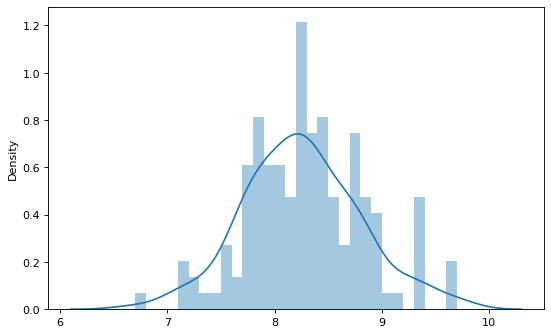

In [53]:
# Histogram of imdb ratings over the seasons
sns.distplot(x=exp_data.imdb_rating, bins = 30)

This gives a reason to explore the normality of the ratings further. We can investigate the normality of the ratings by performing the Shapiro-Wilk test. This test is more suitable for smaller samples of data, hence we believe that it works well with this particular dataset. 


In [54]:
# Performing Shapiro-Wilk test to ensure normality
# Code snippet taken from http://signalsurgeon.com/a-gentle-introduction-to-normality-tests-in-python/
stat, p = scipy.stats.shapiro(exp_data.imdb_rating)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpretation
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.987, p=0.162
Sample looks Gaussian (fail to reject H0)


Since we failed to reject the null hypothesis ($H_0$), there is strong evidence that IMBd ratings follow a normal distribution, meaning the mean will represent the centre of the data best. 

### Character Analysis
In this section, we perform a character analysis. We start by finding the number of characters in the show and identifying the most common characters in the show. We believe that it's important to include the 20 most common characters in the show (i.e. characters with the most lines in the series) in the reunion episode to appease the fans and ensure that no main characters are left out of the reunion. 

In [55]:
# all_characters is a list of every character in the series sorted by number of lines
all_characters = schrute.groupby('character').count()[['index']].sort_values('index', ascending=False).index.values
print("The total number of characters in the series is: ", len(all_characters))

# top 20 main characters 
main_characters = all_characters[:20]
print("The 20 most common characters are: ",main_characters)

The total number of characters in the series is:  318
The 20 most common characters are:  ['Michael' 'Dwight' 'Darryl' 'Jim' 'Pam' 'Andy' 'Angela' 'Kevin' 'Phyllis'
 'Kelly' 'Toby' 'Jan' 'Stanley' 'Holly' 'Nellie' 'Gabe' 'David' 'Pete'
 'Jo' 'Donna']


Now, we create visualisations for the number of spoken lines of the most important characters in the series to get a better understanding of the distribution of results.

<AxesSubplot:xlabel='character'>

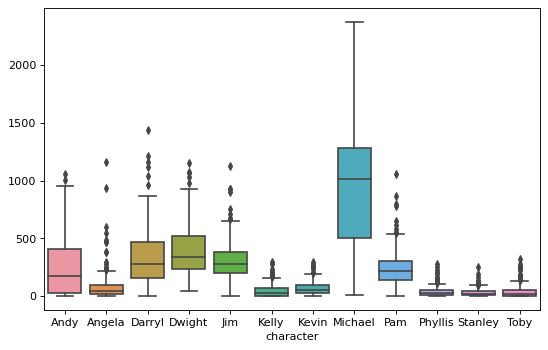

In [56]:
# Create a copy of transcripts
transcript_copy = schrute[['episode_name','character','text']].copy()
#count the number of lines  of each text! 
transcript_copy['length'] = transcript_copy['text'].str.split().str.len()

# Sum length of each string 
transcript_char = transcript_copy.groupby(['episode_name','character'])['length'].sum().reset_index()

# Total per episode 
transcript_total = transcript_copy.groupby(['episode_name'])['length'].sum().reset_index() 
transcript_total.rename(columns = {'length': 'transcript_all_total'}, inplace = True )

# Count the number of character that appear in each episode
character  = transcript_char.groupby(['episode_name'])['length'].count().reset_index()

# We need to consider main character when counting the number of words spoken by them ? may be ? 
main_characters = exp_data['main_chars'].str.split(';',expand = True).unstack().unique().tolist()
main_characters.remove(None)
main_characters
# New final transcript data frame 
final_transcript = transcript_char[transcript_char['character'].isin(main_characters)].pivot_table(index='episode_name',columns='character',values='length').reset_index('episode_name')
final_transcript = final_transcript.fillna(0) # we will all the NA's so we don't get an error
sns.boxplot(data = final_transcript)


From the plot above, we can see that Michael has the highest average number of lines but also the largest distribution. Most characters that we look at have outliers, which suggests that some episodes focus more on certain characters than others. We can also deduce that Michael, Dwight, Darryl, Jim, Pam and Andy are more significant to the show than other characters.

## Writer Analysis

A writer of an episode is undoubtedly a significant factor when considering the `imdb_rating` and general audience enjoyment of the episode. Therefore, we produced a boxplot portraying the "top writers" (i.e. 3 episodes or more) against the `imdb_rating` that the writers' respective episodes received.

We decided to remove writers who only contributed to 2 episodes or less from the analysis, due to the possibility that even if their episodes had received high IMDb ratings, we cannot be certain that they could reproduce these high ratings given only a sample of 2 episodes.

<AxesSubplot:xlabel='writer', ylabel='imdb_rating'>

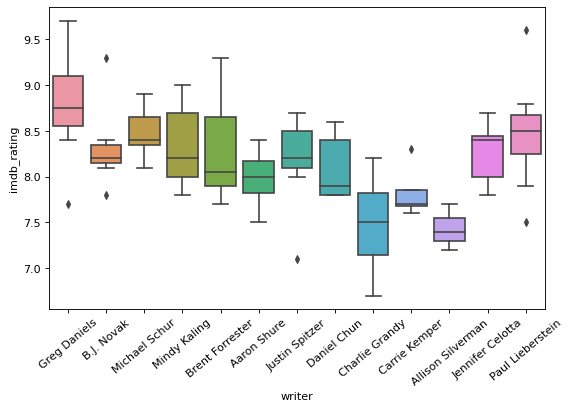

In [57]:
# Making a box plot with writers of more than one episode  
writers_ep = exp_data[["writer","episode_name", "imdb_rating"]]

# List of writers
all_writers = list(dummies_writers)
writer_episode_count = []

for i in all_writers:
    name = i
    a = exp_data[f"{name}"].sum()
    writer_episode_count.append(a)

prolific_writers = pd.DataFrame(zip(all_writers, writer_episode_count))
prolific_writers.columns = ["writer", "episodes"]

# Remove writers who have only less than 3 episodes
prolific_writers = prolific_writers[prolific_writers.episodes >= 3]

# Inner join
top_writers = pd.merge(writers_ep, prolific_writers, on = "writer", how = "inner")

# Boxplot
writer_boxplot = sns.boxplot(y="imdb_rating", x="writer", data=top_writers)
writer_boxplot.set_xticklabels(writer_boxplot.get_xticklabels(), rotation=40)
writer_boxplot

In [58]:
# Statistics for the writers we're considering
nbc_writers = top_writers.groupby("writer").imdb_rating.describe().reset_index().round(2)

nbc_writers.loc[(nbc_writers.writer == "Greg Daniels") |
                (nbc_writers.writer == "Paul Lieberstein") |
                (nbc_writers.writer == "Michael Schur")]

,writer,count,mean,std,min,25%,50%,75%,max
7,Greg Daniels,8.0,8.81,0.66,7.7,8.55,8.75,9.10,9.7
10,Michael Schur,7.0,8.49,0.28,8.1,8.35,8.40,8.65,8.9
12,Paul Lieberstein,10.0,8.47,0.56,7.5,8.25,8.50,8.67,9.6


From the boxplot and summary statistics above, we can see that the episodes written by Greg Daniels have the highest median IMDb rating of all other writers, surpassing other accomplished writers such as Paul Lieberstein and Michael Shur. 

Additionally, we can see that the maximum IMDb rating for episodes written by Greg Daniels is higher than any other writer. After further analysis, it is revealed that the two highest-ever IMDb ratings for the series were written by Greg Daniels (the episodes 'Goodbye, Michael' and 'Finale' with IMDb scores of 9.7 each).

The writer with the subsequently highest episode IMDb rating is Paul Lierberstein (the episode Stress Relief (Parts 1&2) with an IMDb score of 9.6). However, this episode is displayed as an outlier for the IMDb ratings of the episodes written by Paul Lierberstein.

Overall, it is clear that Greg Daniels is a talented writer who can produce episodes with a very high IMDb rating consistently, and should therefore be considered to be the primary writer of the reunion episode. Additionally, we believe that Paul Lierberstein should be considered to help write the episode, as his input could only improve the possibility of creating a reunion episode that the fans will love.

### Director Analysis
Another important feature to consider is the director of the episode. We produce another boxplot portraying the "top directors" (i.e. 3 episodes or more) against the `imdb_rating` that the directors' respective episodes received.

<AxesSubplot:xlabel='director', ylabel='imdb_rating'>

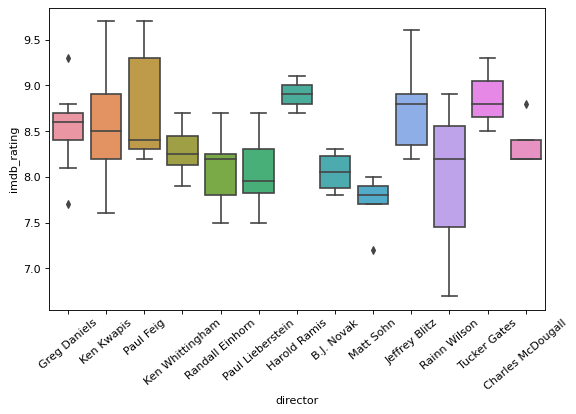

In [59]:
# Writer vs rating boxplot
# make a box plot with writers of more than one episode  
directors_ep = exp_data[["director","episode_name", "imdb_rating"]]

# List of writers
all_directors = list(dummies_director)
#all_directors_suffix = [i + suffix for i in all_directors]
director_episode_count = []

for i in all_directors:
    name = i
    a = exp_data[f"{name}"].sum()
    director_episode_count.append(a)

prolific_directors = pd.DataFrame(zip(all_directors, director_episode_count))
prolific_directors.columns = ["director_names", "episodes"]

# Remove the (Dir) suffix
names = prolific_directors["director_names"].squeeze().to_list()
stripped_names = [s.strip(' (Dir)') for s in names]

prolific_directors["director"] = stripped_names
prolific_directors = prolific_directors.drop(columns = ["director_names"])

# Remove writers who have only less than 3 episodes
prolific_directors = prolific_directors[prolific_directors.episodes > 2]

# Inner join
top_directors = pd.merge(directors_ep, prolific_directors, on = "director", how = "inner")

# Boxplot
director_boxplot = sns.boxplot(x="director", y="imdb_rating",data=top_directors)
director_boxplot.set_xticklabels(director_boxplot.get_xticklabels(), rotation=40)
director_boxplot

In [60]:
# Statistics for the directors we're considering
nbc_directors = top_directors.groupby("director").imdb_rating.describe().reset_index().round(2)

nbc_directors.loc[(nbc_directors.director == "Ken Kwapis") | 
                    (nbc_directors.director == "Paul Feig") |
                    (nbc_directors.director == "Jeffrey Blitz") |
                    (nbc_directors.director == "Tucker Gates")]


,director,count,mean,std,min,25%,50%,75%,max
4,Jeffrey Blitz,7.0,8.73,0.48,8.2,8.35,8.8,8.90,9.6
5,Ken Kwapis,10.0,8.60,0.61,7.6,8.20,8.5,8.90,9.7
8,Paul Feig,13.0,8.72,0.51,8.2,8.30,8.4,9.30,9.7
12,Tucker Gates,3.0,8.87,0.40,8.5,8.65,8.8,9.05,9.3


We can see from the boxplot and summary statistics above that there is a wider range of directors to consider for the reunion episode. Directors such as Ken Kwapis and Paul Feig have the highest maximum IMDb episode rating compared to other directors, whereas they have lower median episode ratings in comparison.

The director with the highest median IMDb episode rating (8.9) is Harold Ramis, however, the maximum rating of an episode directed by Harold Ramis is 9.1, which can be improved. Unfortunately, he has since passed away so cannot participate in the reunion episode anymore. To account for this, we observe the directors Jeffrey Blitz and Tucker Gates, who each have a median IMDb episode rating of 8.8. When comparing these directors, we can see that Jeffrey Blitz has a higher maximum IMDb episode rating (9.6) compared to Tucker Gates (9.3). 


Overall, the perfect director for the reunion will strike a balance between having produced top quality, highly rated episodes, and also show that they can do so consistently. Taking this into account, the two directors we suggest are Paul Feig and Jeffrey Blitz. Both directors have shown that they can create high rated episodes, so it is important to consider the relationship between the director and the writers, and how this might impact the episode rating and therefore the decision for which directors/writers to decide on.

Specifically, we can note that Jeffrey Blitz directed the highly rated 'Stress Relief (Parts 1&2) episode, with Paul Lieberstein writing the episode. Additionally, we can note that Paul Feig directed the highly rated 'Goodbye, Michael' episode, with Greg Daniels writing the episode. Therefore, it is worthwhile considering these director/writer pairs to create the perfect reunion episode.


# Model Fitting and Tuning

In this section we try various models to fit our data: linear model, ridge, ridge kernel, lasso, and decision trees. We then observe what models produce the best results according to their respective root-mean-square-error values.

We use the following helper functions in the model fitting:

In [61]:
# Helper function for getting the model coefficients

def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

# Helper function to see how well the model is fit

def model_fit(m, X, y, plot = False):
    """Returns the root mean squared error of a fitted model based on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    rmse = mean_squared_error(y, y_hat, squared=False)
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
        plt.show()
    
    return rmse

## Building various models with the most relevant features
Considering our previous exploratory data analysis, we decided on the most relevant features in our model, which includes the top 6 main characters, as well as the preferred writers and directors we are considering.

In [62]:
features = ["Michael", "Dwight", "Darryl", "Pam", "Jim", "Andy",
            "Greg Daniels", "Paul Lieberstein", "Paul Feig (Dir)"]

X_train_f = X_train[features]
X_test_f = X_test[features]

#### Linear model

In [63]:
# Preparing the pipeline for modelling
# Linear model
lm = make_pipeline(StandardScaler(), LinearRegression()).fit(X_train_f, y_train)

linear_model_fit = model_fit(lm, X_test_f, y_test, plot=False)
print(f"Linear model RMSE: {linear_model_fit.round(3)}")

Linear model RMSE: 0.521


The linear model Root-Mean-Square-Error (RMSE) of 0.521 provides a fair estimate of the deviation in the data. Next, we try a ridge model.

#### Ridge model

In [64]:
# Ridge model
alphas = np.linspace(0.1, 50, num=250)

# Grid search
ridge_gs = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        Ridge()
    ),
    param_grid={'ridge__alpha': alphas},
    cv=KFold(5, shuffle=True, random_state=1234),
    scoring="neg_root_mean_squared_error"
).fit(X_train_f, y_train)

Obtaining the neccesary parameters allows us now to test the model with the training data in the model fitting process.

In [65]:
ridge_model = make_pipeline(
    StandardScaler(),
    Ridge(alpha=ridge_gs.best_params_["ridge__alpha"])).fit(X_train_f, y_train)

ridge_model_fit = model_fit(ridge_model, X_test_f, y_test, plot=False)
print(f"Ridge model RMSE: {ridge_model_fit.round(3)}")

Ridge model RMSE: 0.518


The ridge model RMSE of 0.518  is an improvement from the ridge model, however the difference is negligible and the ridge model is ultimately insignificantly better in the ridge model. Next, we try a lasso model.

#### Lasso model

In [66]:
# Lasso model

alphas = np.linspace(0.01, 1, num=100)

l_gs = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        Lasso()
    ),
    param_grid={'lasso__alpha': alphas},
    cv=KFold(5, shuffle=True, random_state=1234),
    scoring="neg_root_mean_squared_error"
).fit(X_train_f, y_train)

lasso_model = make_pipeline(
    StandardScaler(),
    Lasso(alpha=l_gs.best_params_["lasso__alpha"])).fit(X_train_f, y_train)

lasso_model_fit = model_fit(lasso_model, X_test_f, y_test, plot=False)
print(f"Lasso model RMSE: {lasso_model_fit.round(3)}")

Lasso model RMSE: 0.515


The lasso model RMSE of 0.515 indicates a better estimate in comparison to the linear and ridge models, but the difference of the model RSME's explored so far is insignificant. Certain characters may be heavily correlated with others. Hence those variables are probably not independent, which explains the reason why models such lasso would remove those variables by penaltising them. In practice the reunion without the main characters is an unfortunate decision. Next, we try a kernel-ridge model. 

#### Kernel-Ridge

In [67]:
# Kernel-Ridge model
alphas = np.logspace(-3, 0, num = 50)
gammas = np.logspace(-3, 0, num = 50)

kernel_ridge_gs = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        KernelRidge(kernel = 'rbf')),
        param_grid=
        {'kernelridge__alpha': alphas},
        cv = KFold(5, shuffle = True, random_state=1234),
        scoring="neg_root_mean_squared_error"
).fit(X_train_f, y_train)

best_alpha_kr = kernel_ridge_gs.best_params_["kernelridge__alpha"]
kernel_ridge_model = make_pipeline(
        StandardScaler(),
        KernelRidge(kernel='rbf', alpha = best_alpha_kr)).fit(X_train_f, y_train)
        
kernel_ridge_fit = model_fit(kernel_ridge_model, X_test_f, y_test, plot=False)
print(f"Kernel-Ridge model RMSE: {kernel_ridge_fit.round(3)}")

Kernel-Ridge model RMSE: 0.541


The kernel-ridge model test RMSE of 0.541 is also quite close to the previous models, if not marginally worse. 

#### Regression Decision Tree

In [68]:
# regression tree
max_depths = np.linspace(1, 20, num = 50)

reg_tree_gs = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        DecisionTreeRegressor(criterion = "mse", random_state = 1234)),
        param_grid=
        {'decisiontreeregressor__max_depth': max_depths},
        cv = KFold(5, shuffle = True, random_state=1234),
        scoring="neg_root_mean_squared_error"
).fit(X_train_f, y_train)

# Regression tree model fit
best_depth = reg_tree_gs.best_params_["decisiontreeregressor__max_depth"]
reg_tree_model = make_pipeline(
    StandardScaler(),
    DecisionTreeRegressor(criterion="mse", random_state = 1234, max_depth=best_depth)).fit(X_train_f, y_train)
reg_tree_fit = model_fit(reg_tree_model, X_test_f, y_test, plot=False)
print(f"Regression tree model RMSE: {reg_tree_fit.round(3)}")

Regression tree model RMSE: 0.493


The regression tree model test RMSE of 0.493 is the best estimate so far, however the improvement compared to the other models is marginal.

# Discussion & Conclusions
Let us compare the results together by combining them in a table shown below.

In [69]:
# RMSE comparison 
test_rmse = [linear_model_fit, ridge_model_fit, lasso_model_fit,  kernel_ridge_fit, reg_tree_fit]
train_rmse = [lm.score(X_train_f, y_train), ridge_model.score(X_train_f, y_train), lasso_model.score(X_train_f, y_train),kernel_ridge_model.score(X_train_f, y_train), reg_tree_model.score(X_train_f, y_train)]
models = ["linear", "ridge","lasso", "kernel ridge", "decision tree"]

rmse_comparison = pd.DataFrame(data = zip(models, train_rmse, test_rmse), columns = ["model", "train_rmse","test_rmse"])

rmse_comparison.round(3)

,model,train_rmse,test_rmse
0,linear,0.409,0.521
1,ridge,0.409,0.518
2,lasso,0.406,0.515
3,kernel ridge,0.492,0.541
4,decision tree,0.476,0.493


The difference in the model test RMSE's is negligible, with the decision tree model providing the best model fit overall. Due to the similarity in model performace with respect to RMSE, other factors determining the optimal model should be considered, such as model complexity, cost and computational efficiency. 

The decision tree, while exhibiting the lowest RMSE, has a caveat of fiting the data extremely well at the cost of an increased complexity that will lead to overfitting and potentially capturing noise.

As mentioned previously, there is a high likelihood of characters being correlated with each other throughout the series. Therefore, to account for these correlations, we choose a ridge regression to be the final choice for the predictive model. The ridge regression model is a linear regression model which penalises on the coefficients to a standard least squares problem. This means that the model removes the features that seem to be affecting the model negatively. The RMSE gives a good estimate of the distribution of our errors.

It is preferred to have a simpler model that captures most of the variances in the data, while keeping the computational complexity at a minimal; as there is little value offered by more complex models for this particular case. 

We plot the results of the ridge regression model on our data below:

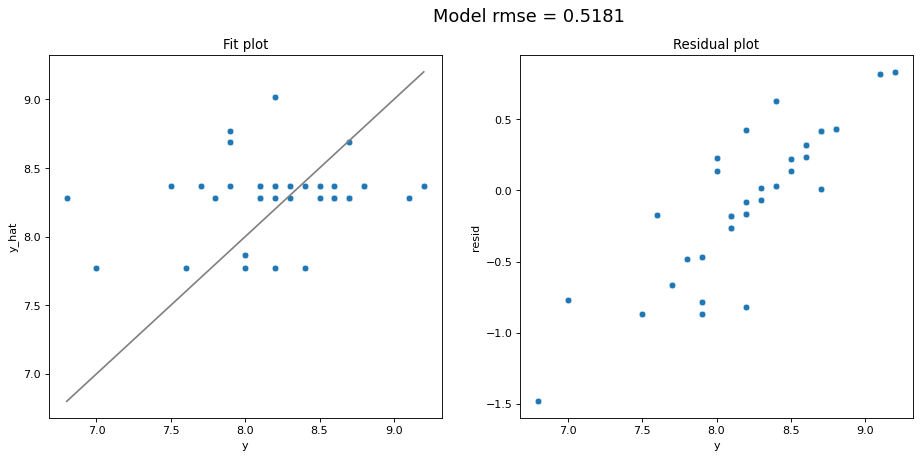

0.5180868610268539

In [70]:
model_fit(ridge_model, X_test_f, y_test, plot=True)

The fit plot on the left plots $\hat y$ (estimated output) against $y$ (sample output), where the estimated output is the prediction that the model calculates for the IMDb rating.

The model offers a good predictive performance for the observed range of 8.0 to 8.5, as the data fits in a linear fashion. It is important to emphasize that the model also offers an optimistical estimation of the IMDb rating, as it tends to predict the rating higher in other observed ranges. There is an estimated value for the IMDb rating of circa 8.4, which corresponds to an observed value of circa 6.9. This optimistical tendency could be due to the fact that we have considered a limited number of features for inclusion in the model that are positive features, which impact on the IMDb rating in an increasing fashion. However, we did not consider specific individual or a set of characters that may drop the rating due to low popularity or less acceptance by the audience. 

The plot on the right shows the variances that were not captured by the Ridge model against the observed output $y$ (In this case, the IMDb rating). This is what is called residuals, which are portions of the data that could not be predicted by the model. The standard deviation of the residuals (or the model RMSE), has a value of 0.51, indicating a prediction error of 0.51 units in the IMDb rating. An ideal result for the residual plot would be a random pattern of the data points, which would indicate a good model fit to the data, however the residual plot in this case produces a relatively positive linear trend, indicating that the model is not the best fit for the data.

Although the ridge regression model does not provide a perfect fit for the data, this only indicates that there is no perfect map towards a reunion episode with the highest possible rating. There is still a lot of room for creativity and flexibility with regards to what the reunion episode should include, however we will provide NBC with our best recommendations nonetheless.


### NBC recommendations

Summarising the discoveries found in the exploratory analysis phase and the predictive model built, we can help to craft the perfect reunion episode that the fans will love. The three things considered when building this episode were the characters involved, the writer(s) of the episode, and the director.

We strongly believe that the most popular characters of the series (i.e. the characters with the most involvement, based on a number of lines throughout the show) should all be included in the episode. These characters include Michael, Dwight, Darryl, Jim, Pam, Andy, Angela, Kevin, Phyllis', Kelly, Toby, Jan, Stanley, Holly, Nellie, Gabe, David, Pete, Jo, and Donna. That being said, we believe that certain characters should feature more than others, and Michael's presence is especially crucial. Additionally, we believe that the episode should focus more heavily on characters such as Dwight, Jim, Pam, Darryl and Andy. 

One of the most important decisions for creating the reunion episode was who is going to write the script. There are several strong candidates throughout the series to choose from, however, we believe that Greg Daniels should be the main writer of the show. We also suggest that Paul Lierberstein should help Greg Daniels write the episode as a sort of back-seat writer, as his input will inevitably prove to be invaluable. 

Finally, we believe that Paul Feig should direct the reunion episode, as he has shown in the past that he can create high-quality episodes, many of which are fan favourites.

In [71]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf Report.ipynb

[NbConvertApp] Converting notebook Report.ipynb to pdf
[NbConvertApp] Support files will be in Report_files\
[NbConvertApp] Making directory .\Report_files
[NbConvertApp] Making directory .\Report_files
[NbConvertApp] Making directory .\Report_files
[NbConvertApp] Making directory .\Report_files
[NbConvertApp] Making directory .\Report_files
[NbConvertApp] Writing 109950 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | b had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 207297 bytes to Report.pdf


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1068ffe5-a3f5-4d99-be83-e6917379c929' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>